# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [53]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy
import torch
from PIL import Image

sns.set_theme()

In [4]:
from subpair import extract, pairwise_cosine

# Setup

In [5]:
img_folder = Path("../higherANML/experiments/data/ImageNet84")
feats_folder = Path("/users/l/f/lfrati/scratch/OmnImage_data/torchvision.models.vgg_ce631fc9ca0278a2")
cls2label = {}
with open(img_folder / "imagenet_class_index.json") as f:
    class_idx = json.load(f)
    cls2label = dict(class_idx.values())
    label2cls = {v: k for k, v in cls2label.items()}

In [6]:
all_feature_files = sorted(feats_folder.iterdir())
cls2file = {f.stem: f for f in all_feature_files}
imgcls_file = all_feature_files[0]
imgcls = imgcls_file.stem
print(f"Working with class: {imgcls} ({cls2label[imgcls]})")

Working with class: n01440764 (tench)


In [7]:
X = np.load(imgcls_file)

In [8]:
distances = pairwise_cosine(X)

In [10]:
num_samples = 20
best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)

100%|██████████| 3000/3000 [00:04<00:00, 677.36it/s]


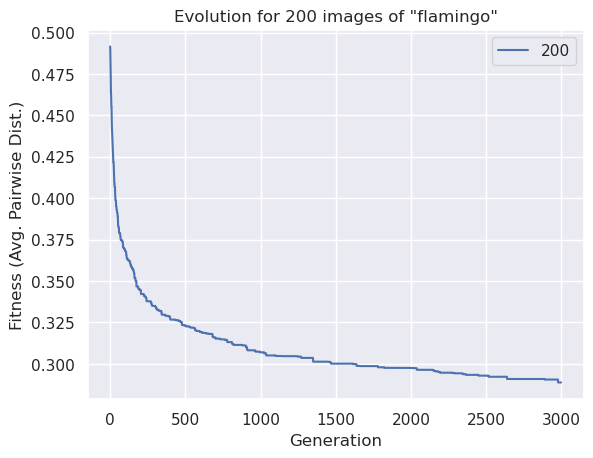

In [36]:
def plot_evolution(stats, num_samples=None, clsname=None):
    label = None
    if num_samples is not None:
        label = str(num_samples)
    normed_fits = np.array(stats["fits"]) / ((num_samples*(num_samples-1))/2)

    plt.plot(normed_fits, label=label)
    plt.xlabel("Generation")
    plt.ylabel("Fitness (Avg. Pairwise Dist.)")
    title = "Evolution"

    if num_samples is not None:
        title += f" for {num_samples} images"
    if clsname:
        title += f' of "{clsname}"'
    elif num_samples is not None:
        title += " per class"
    plt.title(title)
    plt.legend()

plot_evolution(stats, num_samples, cls2label[imgcls])

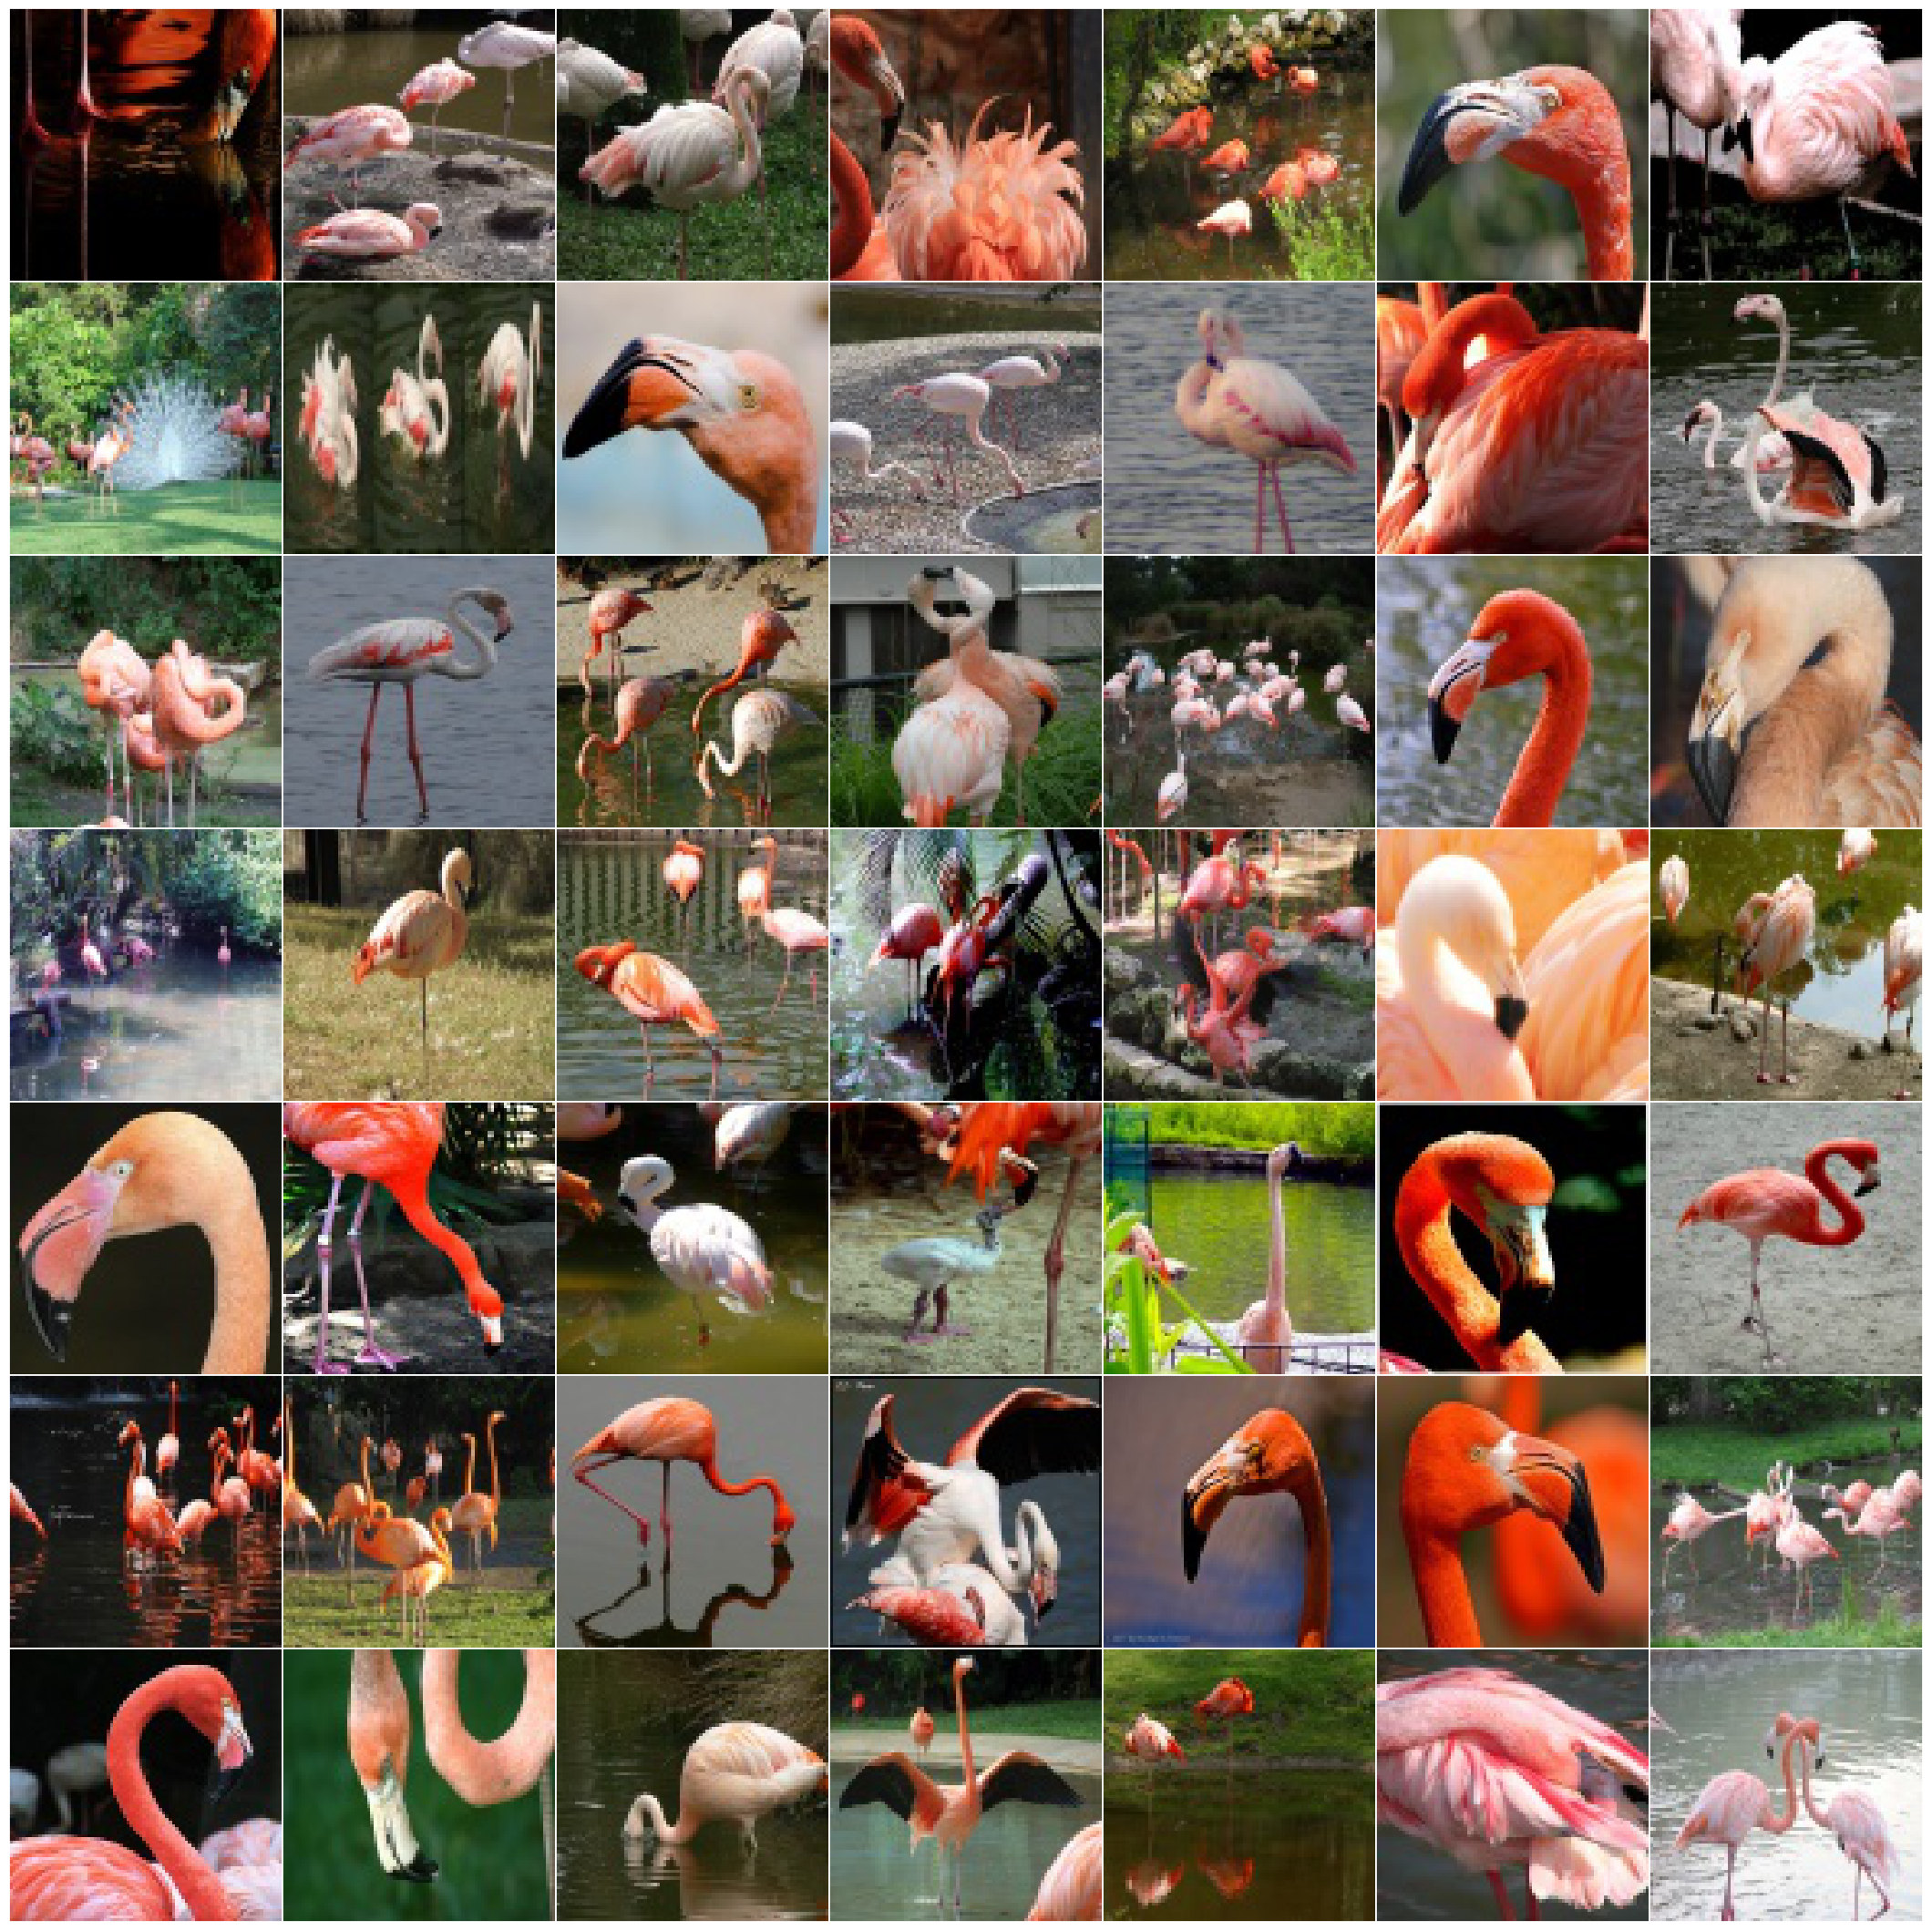

In [78]:
def get_image_paths(clsid):
    cls_folder = img_folder / clsid
    return sorted(cls_folder.iterdir())


def view_images(clsid, img_indices, img_paths=None, pack=False):
    if not img_paths:
        img_paths = get_image_paths(clsid)
    # indices are expected to correspond to the sorted filename ordering.
    selected_paths = [img_paths[i] for i in img_indices]
    nrows = int(np.sqrt(len(selected_paths)))
    ncols = int(np.ceil(len(selected_paths) / nrows))
    gkw = {}
    if pack:
        gkw["wspace"] = 0.0
        gkw["hspace"] = 0.0
        gkw["left"] = 0.0
        gkw["right"] = 1.0
        gkw["bottom"] = 0.0
        gkw["top"] = 1.0
    fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(ncols*3, nrows*3), gridspec_kw=gkw)
    if not pack:
        fig.suptitle(cls2label[clsid], fontsize=32)
    for i, f in enumerate(selected_paths):
        ax = axs[i // ncols, i % ncols]
        ax.imshow(Image.open(f), cmap='gray')
    for r in range(nrows):
        for c in range(ncols):
            ax = axs[r, c]
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)


view_images(imgcls, np.arange(49), pack=True)

# Single Class Analysis

In [12]:
imgcls_file = np.random.choice(all_feature_files)
imgcls = imgcls_file.stem
print(f"Computing image distances for class: {imgcls} ({cls2label[imgcls]})")
X = np.load(imgcls_file)
distances = pairwise_cosine(X)

Computing image distances for class: n02007558 (flamingo)


In [14]:
sample_sizes = [10, 20, 50, 100, 200]
results = []
for i, num_samples in enumerate(sample_sizes):
    best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)
    results.append({"num_samples": num_samples, "best": best, "stats": stats})

100%|██████████| 3000/3000 [00:33<00:00, 89.68it/s]


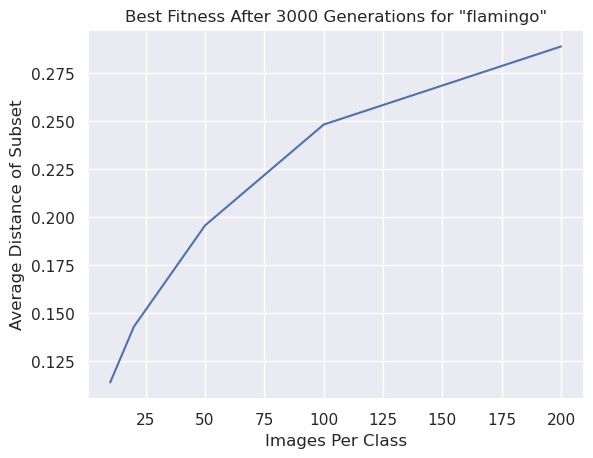

In [15]:
final_fitnesses = [r["stats"]["fits"][-1] / ((N*(N-1))/2) for N, r in zip(sample_sizes, results)]
plt.plot(sample_sizes, final_fitnesses)
plt.xlabel("Images Per Class")
plt.ylabel("Average Distance of Subset")
_ = plt.title(f'Best Fitness After 3000 Generations for "{cls2label[imgcls]}"')

# Aggregating Multiple Classes

In [27]:
import itertools


def compute_evolved_subsets(distances, sample_sizes=None, clsname=None, plot=False):
    if not sample_sizes:
        sample_sizes = [10, 20, 50, 100, 200]
    results = []
    for i, num_samples in enumerate(sample_sizes):
        best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)
        results.append({"num_samples": num_samples, "best": best, "stats": stats})
        if plot:
            plot_evolution(stats, num_samples, clsname)
    return results


def compute_evolved_subsets_for_class(imgcls_file, sample_sizes=None, plot=False):
    imgcls = imgcls_file.stem
    X = np.load(imgcls_file)
    distances = pairwise_cosine(X)
    return compute_evolved_subsets(distances, sample_sizes, cls2label[imgcls], plot)


def get_fitnesses_for_classes(num_classes=None):
    if num_classes is None:
        cls_files = all_feature_files
    else:
        cls_files = np.random.choice(all_feature_files, size=num_classes, replace=False)
    total = len(cls_files)

    sample_sizes = [10, 20, 50, 100, 200]
    records = []
    for i, f in enumerate(cls_files):
        clsid = f.stem
        clsname = cls2label[clsid]
        print(f"Computing evolved subsets for class {i}/{total}: {clsid} ({clsname})")
        all_stats = compute_evolved_subsets_for_class(f, sample_sizes)
        dists = [r["stats"]["fits"][-1] / ((N*(N-1))/2) for N, r in zip(sample_sizes, all_stats)]
        records.extend(zip(itertools.repeat(clsid), itertools.repeat(clsname), sample_sizes, dists))
    
    return pd.DataFrame.from_records(records, columns=("Class ID", "Label", "Subset Size", "Avg. Dist."))

100%|██████████| 3000/3000 [00:43<00:00, 69.23it/s]


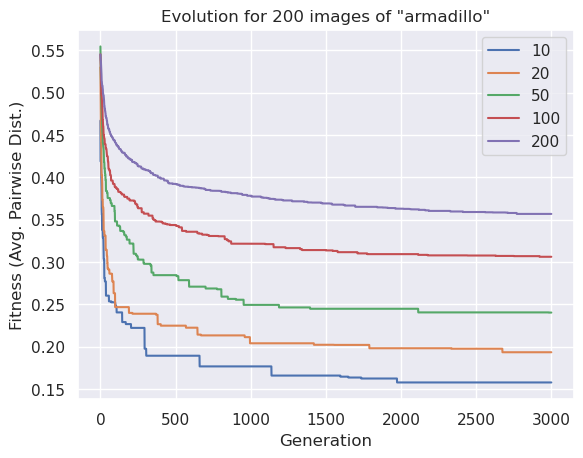

In [37]:
clsname = np.random.choice(list(label2cls.keys()))
clsfile = cls2file[label2cls[clsname]]
res = compute_evolved_subsets_for_class(clsfile, plot=True)

# All Classes Up to N=200

In [18]:
#df = get_fitnesses_for_classes()
df = pd.read_pickle("evolved_subset_fitnesses.pkl")

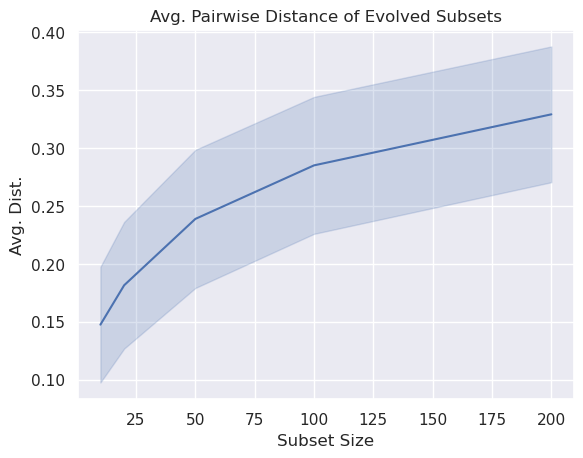

In [44]:
ax = sns.lineplot(data=df, x="Subset Size", y="Avg. Dist.", errorbar="sd")#, hue="Label", legend=False)
_ = ax.set_title("Avg. Pairwise Distance of Evolved Subsets")

In [22]:
df#.to_pickle("evolved_subset_fitnesses.pkl")

,Class ID,Label,Subset Size,Avg. Dist.
0,n01440764,tench,10,0.180353
1,n01440764,tench,20,0.209126
2,n01440764,tench,50,0.240166
3,n01440764,tench,100,0.270542
4,n01440764,tench,200,0.299189
...,...,...,...,...
4995,n15075141,toilet_tissue,10,0.204570
4996,n15075141,toilet_tissue,20,0.196619
4997,n15075141,toilet_tissue,50,0.278168
4998,n15075141,toilet_tissue,100,0.336320


# Study of Non-Monotonic Curves

['Afghan_hound' 'African_grey' 'Bernese_mountain_dog' 'French_horn'
 'Italian_greyhound' 'Kerry_blue_terrier' 'bathing_cap' 'binoculars'
 'burrito' 'chain' 'corn' 'crane' 'gazelle' 'giant_panda' 'maillot'
 'malinois' 'medicine_chest' 'mobile_home' 'puck' 'racer' 'revolver'
 'spatula' 'television' 'toilet_tissue' 'umbrella' 'warthog' 'wild_boar']
['n02088094' 'n01817953' 'n02107683' 'n03394916' 'n02091032' 'n02093859'
 'n02807133' 'n02841315' 'n07880968' 'n02999410' 'n12144580' 'n02012849'
 'n03126707' 'n02423022' 'n02510455' 'n03710637' 'n03710721' 'n02105162'
 'n03742115' 'n03776460' 'n04019541' 'n04037443' 'n04086273' 'n04270147'
 'n04404412' 'n15075141' 'n04507155' 'n02397096' 'n02396427']


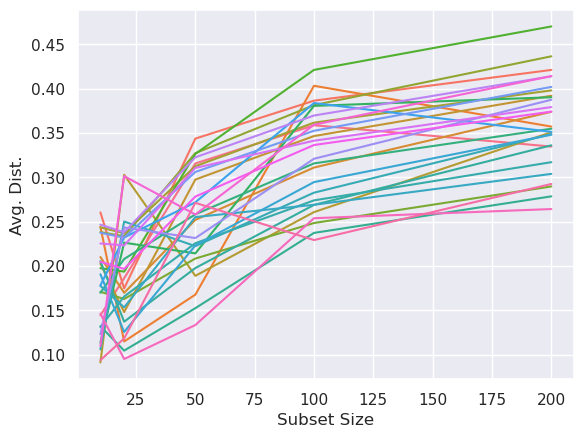

In [20]:
def get_decreasing(group):
    dists = group["Avg. Dist."]
    has_decrease = np.any([n1 > n2 for n1, n2 in zip(dists, dists.iloc[1:])])
    if has_decrease:
        return group
    else:
        return pd.DataFrame()

non_monotonics = df.groupby("Label").apply(get_decreasing)
print(non_monotonics["Label"].unique())
print(non_monotonics["Class ID"].unique())
ax = sns.lineplot(data=non_monotonics, x="Subset Size", y="Avg. Dist.", hue="Label", errorbar=None, legend=False)

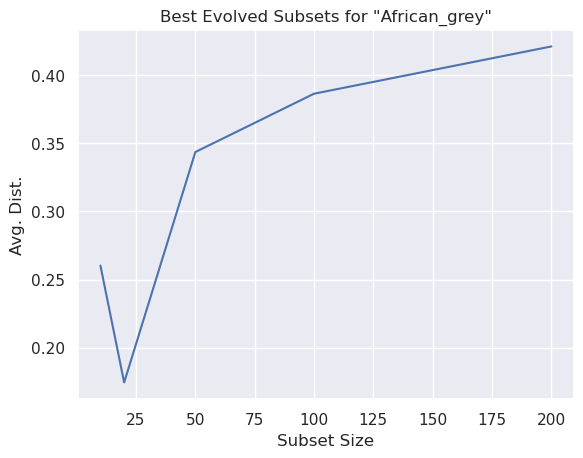

In [41]:
# Plot a single class.
clsname = "African_grey"
oneclass = df.loc[df["Label"] == clsname]
ax = sns.lineplot(data=oneclass, x="Subset Size", y="Avg. Dist.", hue="Label", errorbar=None, legend=False)
_ = ax.set_title(f'Best Evolved Subsets for "{clsname}"')

100%|██████████| 3000/3000 [00:35<00:00, 85.13it/s]


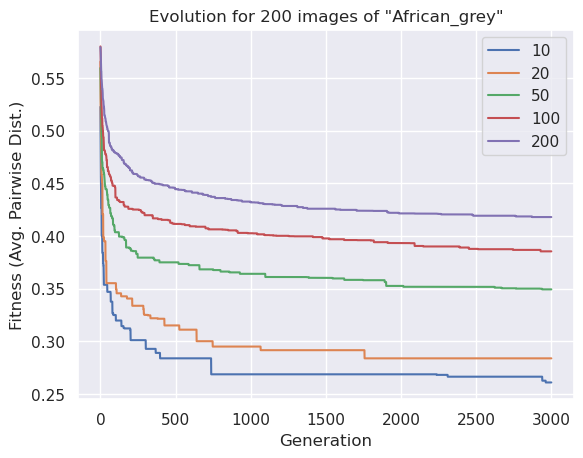

In [45]:
clsfile = cls2file[label2cls[clsname]]
res = compute_evolved_subsets_for_class(clsfile, plot=True)

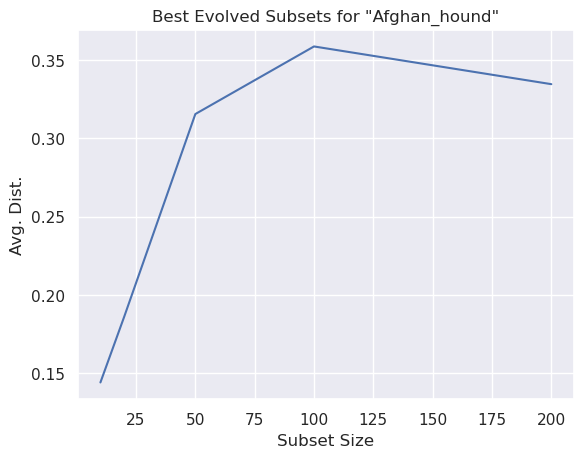

100%|██████████| 3000/3000 [00:54<00:00, 55.55it/s]


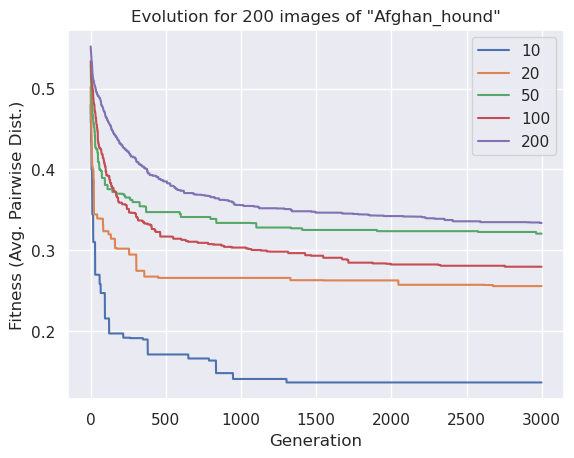

In [40]:
# Plot a single class.
clsname = "Afghan_hound"
oneclass = df.loc[df["Label"] == clsname]
ax = sns.lineplot(data=oneclass, x="Subset Size", y="Avg. Dist.", hue="Label", errorbar=None, legend=False)
_ = ax.set_title(f'Best Evolved Subsets for "{clsname}"')
plt.show()
clsfile = cls2file[label2cls[clsname]]
res = compute_evolved_subsets_for_class(clsfile, plot=True)

# Visualization of Evolved Subset

100%|██████████| 3000/3000 [00:04<00:00, 695.09it/s]


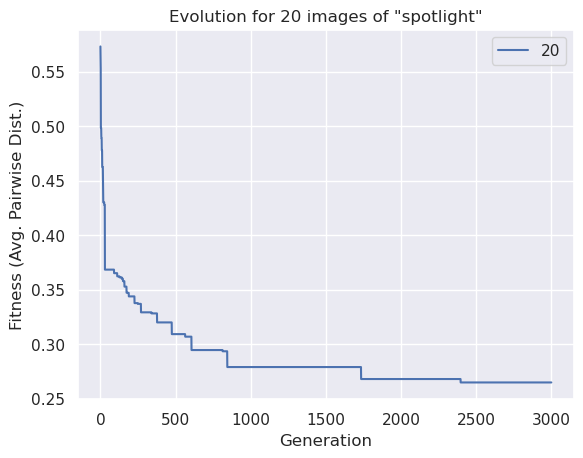

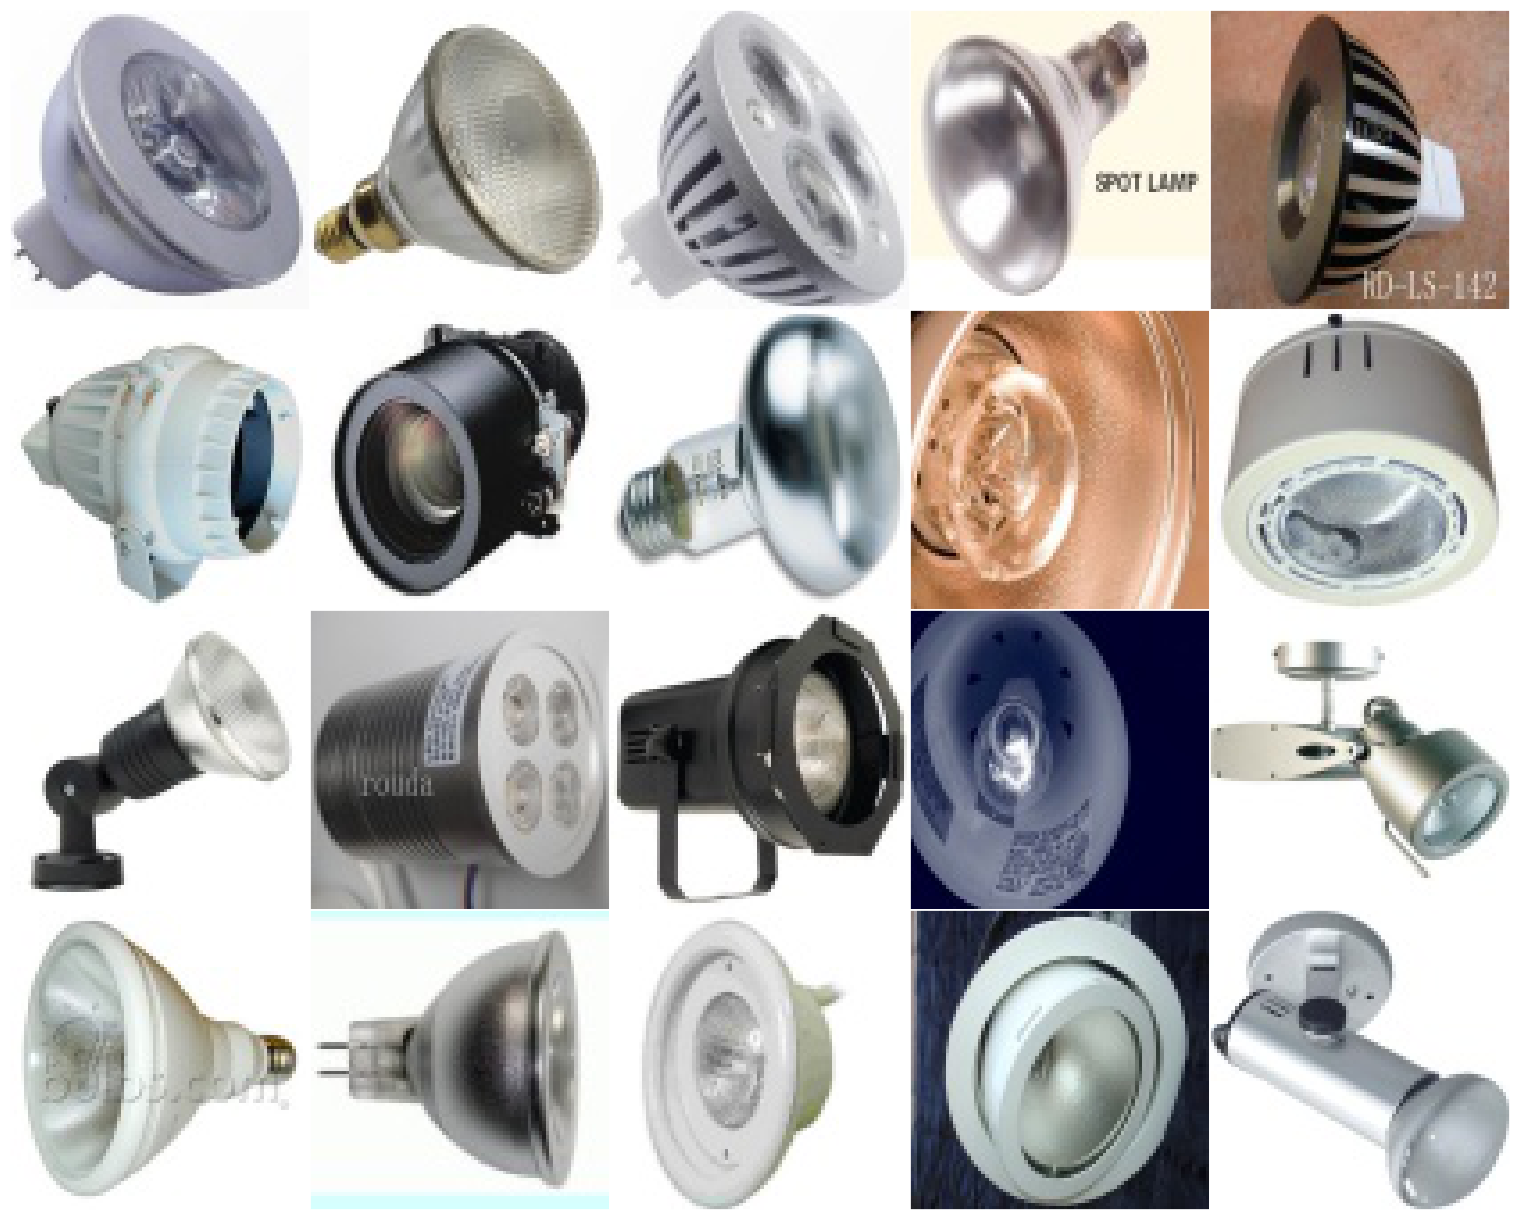

In [72]:
clsname = np.random.choice(list(label2cls.keys()))
clsid = label2cls[clsname]
clsfile = cls2file[clsid]
res = compute_evolved_subsets_for_class(clsfile, [20], plot=True)
plt.show()

view_images(clsid, res[0]["best"], pack=True)

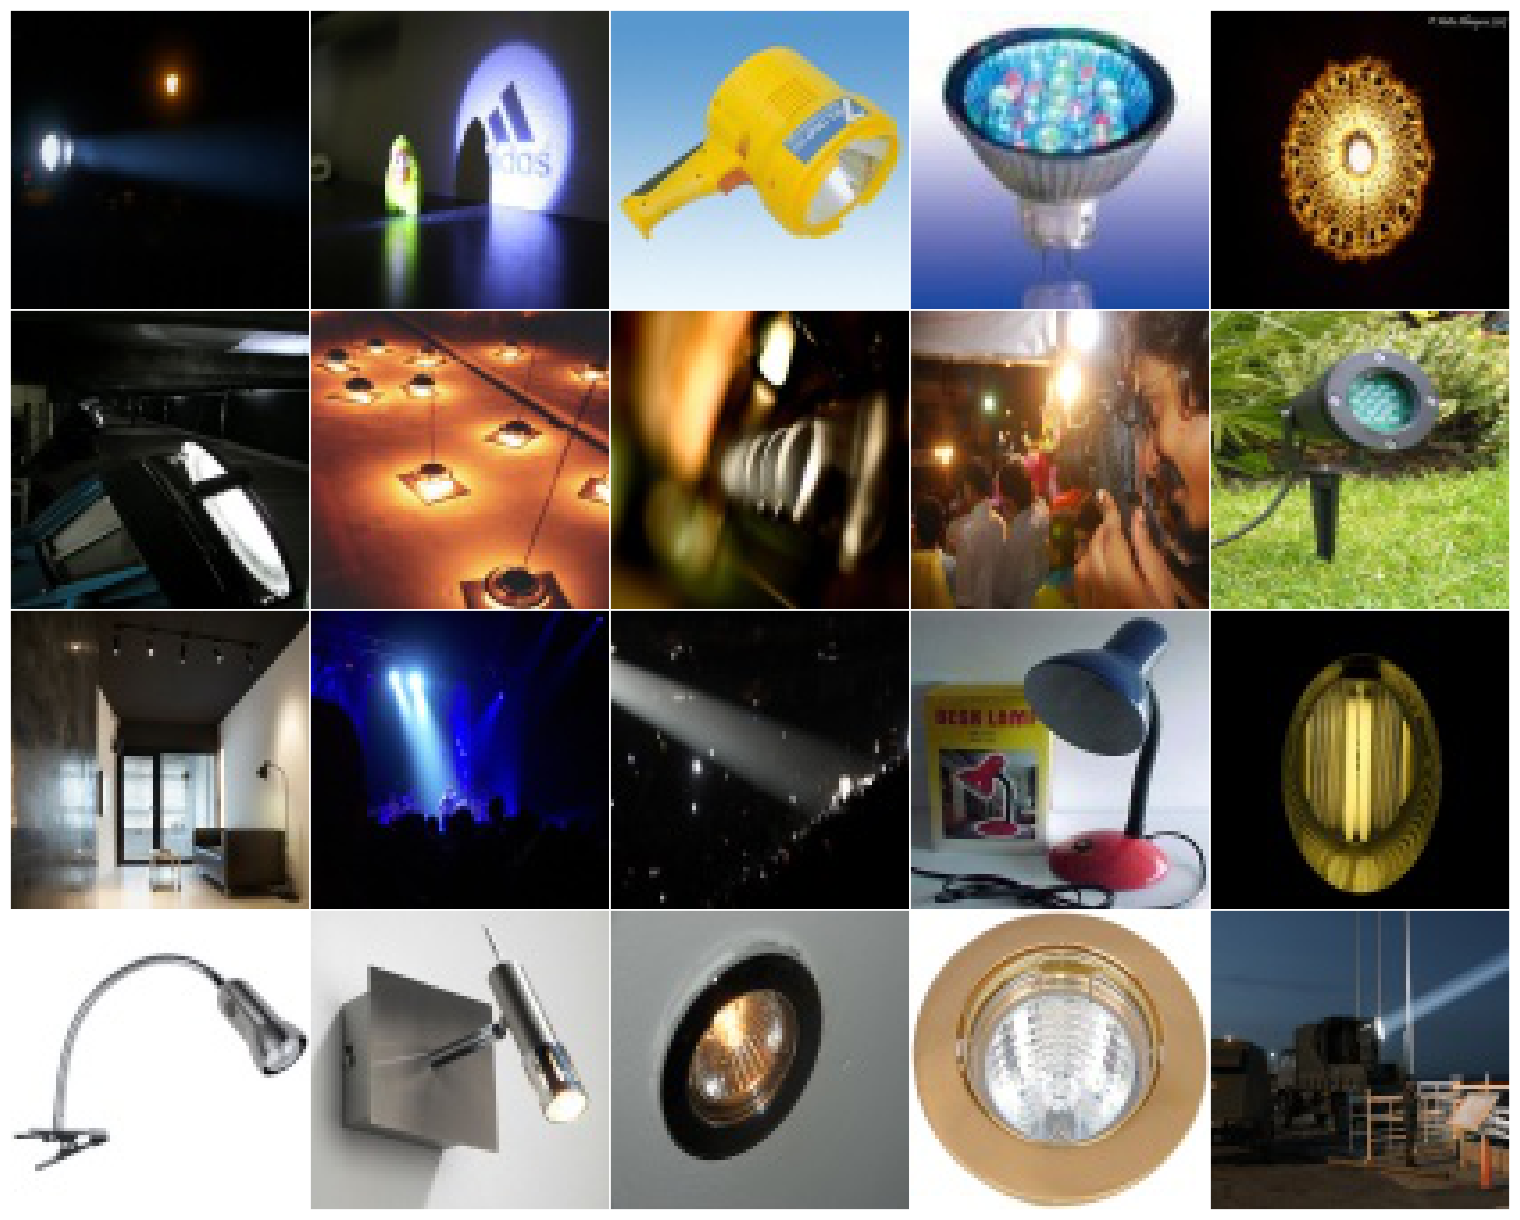

In [80]:
# Random set from the same class.
img_paths = get_image_paths(clsid)
view_images(clsid, np.random.choice(np.arange(len(img_paths)), 20), img_paths, pack=True)

# t-SNE Visualization